In [1]:
from models import UNETModule
import torch
from torch.utils.data import DataLoader


/home/rafael/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()

36

### Water Bodies Dataset

In [10]:
from datasets import WaterBodiesDataset, SimpleWaterBodiesDataset
from torchvision import transforms
import albumentations as A

transform = A.Compose([
    A.RandomCrop(width=256, height=256, p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])


root = "../water-segmentation-vtx/dataset/"
train_dataset = SimpleWaterBodiesDataset(root, mode="train", transform=transform)
val_dataset = SimpleWaterBodiesDataset(root, mode="val")

print("Train dataset length:", len(train_dataset))
print("Val dataset length:", len(val_dataset))

Train dataset length: 801
Val dataset length: 90


In [20]:
aosjdas = SimpleWaterBodiesDataset(root, mode="train")
aosjdas.__getitem__(0)["mask"]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])

(256, 256, 3)


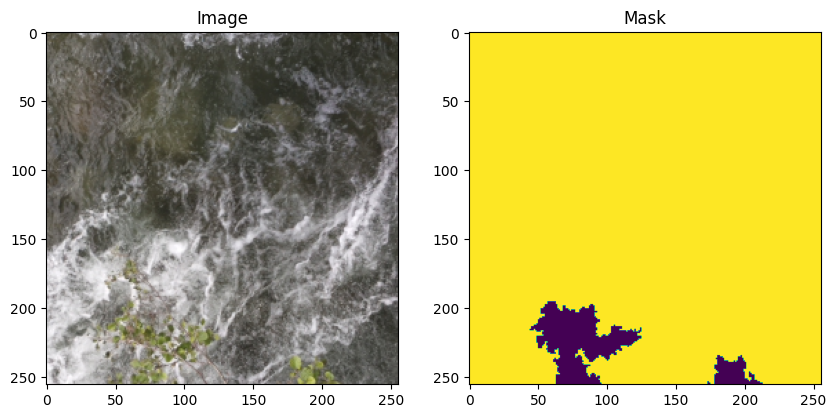


Mask Array:
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]
(1, 256, 256)


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

example = train_dataset.__getitem__(94)
image_array = example["image"]
mask_array = example["mask"]
image = image_array.astype(np.uint8)
mask = np.squeeze(mask_array, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Image")
axes[1].imshow(mask)
axes[1].set_title("Mask")
plt.show()

# print("Image Array:")
# print(image_array)
print("\nMask Array:")
print(mask_array)

print(mask_array.shape)
# HWC (480, 640, 3)
# CHW (3, 480, 640)

#### Dataloader

In [6]:

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=n_cpu)

In [10]:
train_dataset.__getitem__(0)

{'image': array([[[209, 210, 213, ..., 115, 111, 130],
         [209, 210, 214, ..., 131, 147, 149],
         [213, 214, 215, ..., 137, 128, 139],
         ...,
         [117, 114, 111, ..., 101,  88,  88],
         [121, 115, 113, ...,  95,  89,  90],
         [114, 111, 112, ...,  94,  93,  90]],
 
        [[202, 203, 203, ..., 114, 106, 123],
         [202, 203, 204, ..., 130, 142, 142],
         [203, 204, 205, ..., 134, 123, 132],
         ...,
         [114, 111, 107, ..., 103,  87,  87],
         [116, 110, 108, ...,  99,  93,  92],
         [109, 106, 104, ..., 101,  97,  94]],
 
        [[210, 211, 211, ..., 122, 113, 130],
         [210, 211, 212, ..., 138, 149, 149],
         [211, 212, 213, ..., 143, 130, 139],
         ...,
         [109, 106, 104, ..., 116, 101, 101],
         [112, 106, 105, ..., 110, 105, 105],
         [105, 102, 102, ..., 109, 109, 106]]], dtype=uint8),
 'mask': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0

### Training

In [7]:
import torch
import pytorch_lightning as pl
import torchvision
import numpy as np

accelerator = "gpu" if torch.cuda.is_available() else "cpu"

unet_module = UNETModule()

unet_trainer = pl.Trainer(
    max_epochs=10,
    accelerator=accelerator,
    devices=1,
)

unet_trainer.fit(unet_module, train_dataloader, valid_dataloader)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/rafael/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 71.5MB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [8]:
logits  = unet_trainer.predict(unet_module, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
(torch.sigmoid(logits[0]) > 0.5).float().shape

torch.Size([8, 1, 480, 640])

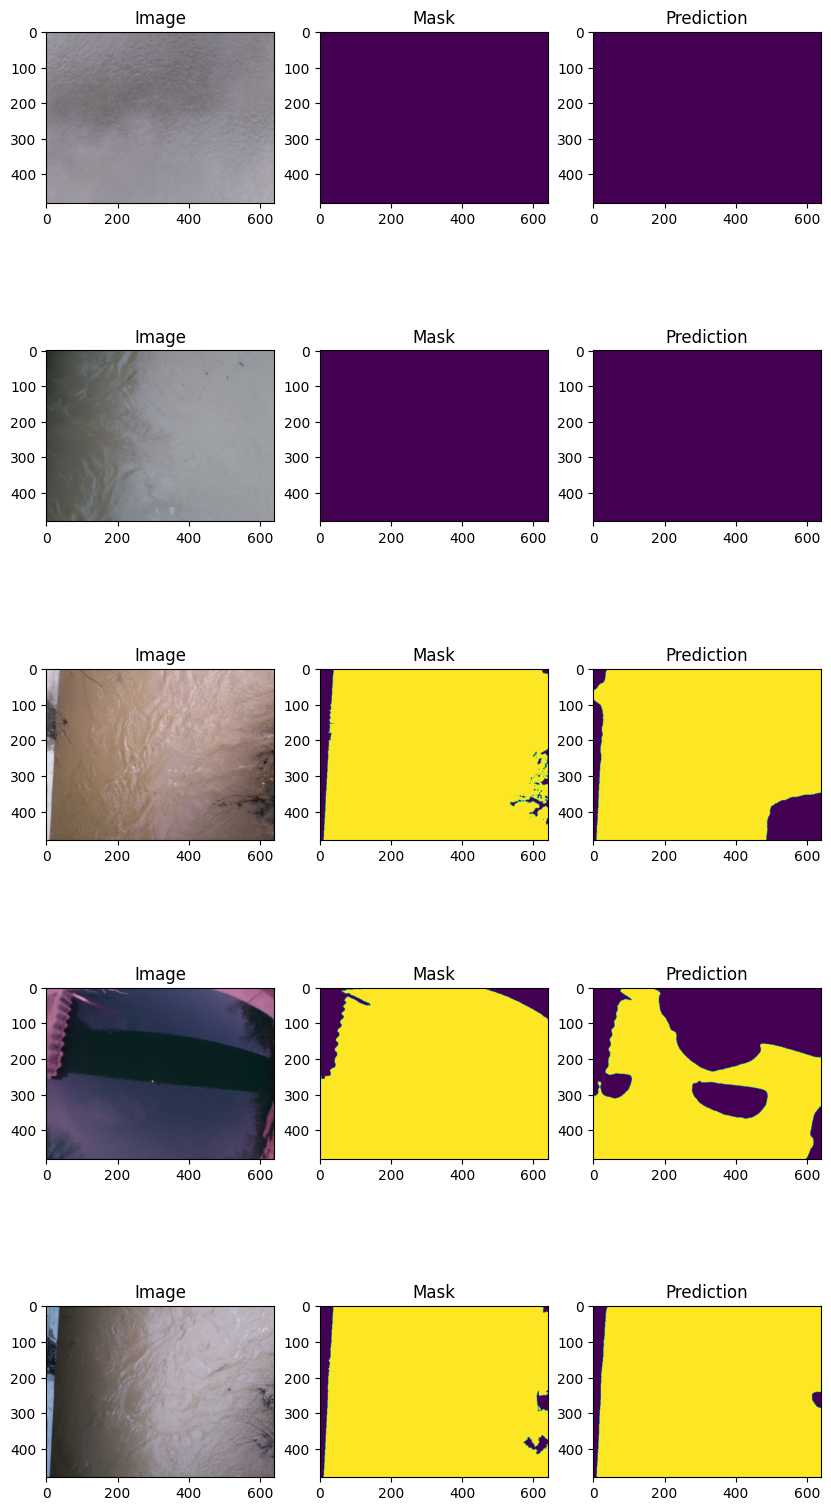

In [10]:
preds = (torch.sigmoid(logits[0]) > 0.5).float()


fig, axes = plt.subplots(5, 3, figsize=(10, 20))
for i in range(5):
    example = val_dataset.__getitem__(i)
    image_array = example["image"]
    mask_array = example["mask"]
    image = Image.fromarray(image_array.transpose(1,2,0), 'RGB')
    mask = Image.fromarray((np.squeeze(mask_array, axis=0)*255).astype(np.uint8))
    prediction = Image.fromarray((np.squeeze(preds[i].cpu().numpy(), axis=0)*255).astype(np.uint8))
    axes[i][0].imshow(image)
    axes[i][0].set_title("Image")
    axes[i][1].imshow(mask)
    axes[i][1].set_title("Mask")
    axes[i][2].imshow(prediction)
    axes[i][2].set_title("Prediction")

